In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

c:\Projects\ml_tests\venv\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# Klasyfikacja binarna
y_train_9 = (y_train == '9')
y_test_9 = (y_test == '9')

In [3]:
from sklearn.linear_model import SGDClassifier

# Uczenie klasyfikatora
sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_9)

SGDClassifier(random_state=42)

In [4]:
from sklearn.model_selection import cross_val_score

# Ocena poprzez 3-krotny sprawdzian krzyżowy
cross_val_score(sgd_classifier, X_train, y_train_9, cv=3, scoring='accuracy')

array([0.9456 , 0.95195, 0.9509 ])

In [5]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
# Ocena poprzez macierz pomyłek
y_train_9_prediction = cross_val_predict(sgd_classifier, X_train, y_train_9, cv=3)
cm = confusion_matrix(y_train_9, y_train_9_prediction)
print(cm)

[[52715  1336]
 [ 1695  4254]]


In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('precyzja: ', precision_score(y_train_9, y_train_9_prediction))
print('pełność: ', recall_score(y_train_9, y_train_9_prediction))
print('śr. harmoniczna F1: ', f1_score(y_train_9, y_train_9_prediction))

precyzja:  0.7610017889087657
pełność:  0.7150781643973777
śr. harmoniczna F1:  0.737325591472398


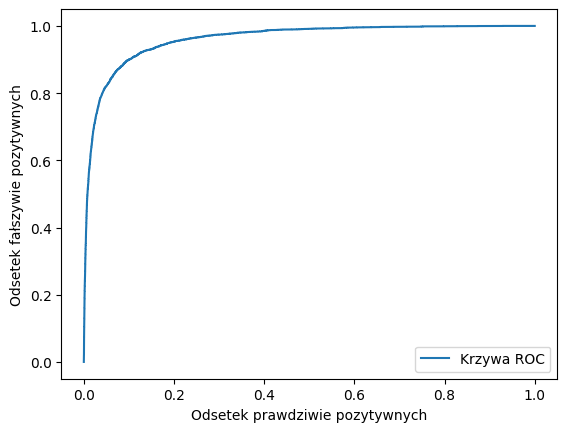

In [7]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Wyniki decyzyjne zamiast przewidywań
y_scores_9 = cross_val_predict(sgd_classifier, X_train, y_train_9, cv=3, method='decision_function')

# Ocena poprzez krzywą ROC
false_positive_rates, true_positive_rates, thresholds = roc_curve(y_train_9, y_scores_9)
plt.plot(false_positive_rates, true_positive_rates, label='Krzywa ROC')
plt.xlabel('Odsetek prawdziwie pozytywnych')
plt.ylabel('Odsetek fałszywie pozytywnych')
plt.legend()
plt.show()


In [8]:
# obszar pod krzywą
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_9, y_scores_9)

0.96114559368217

In [9]:
# zastosowanie klasyfikatora lasu losowego
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [10]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3, method="predict_proba")
y_probas_forest[:2]

array([[0.99, 0.01],
       [1.  , 0.  ]])

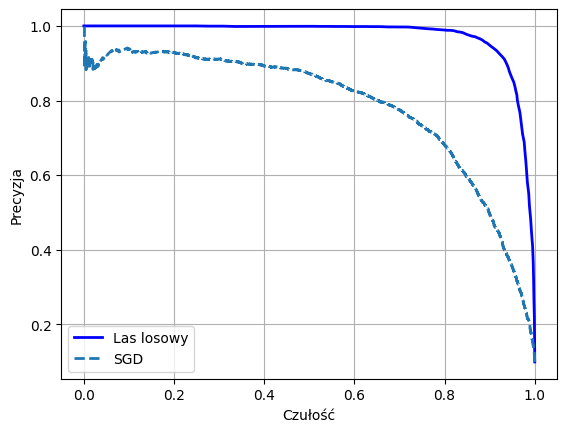

In [11]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores_9)
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_9, y_scores_forest)

plt.plot(recalls_forest, precisions_forest, 'b-', linewidth=2, label='Las losowy')
plt.plot(recalls, precisions, '--', linewidth=2, label="SGD")
plt.xlabel("Czułość")
plt.ylabel("Precyzja")
plt.grid(visible=True)
plt.legend()
plt.show()

Klasyfikacja wieloklasowa

In [12]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [13]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

Analiza błędów

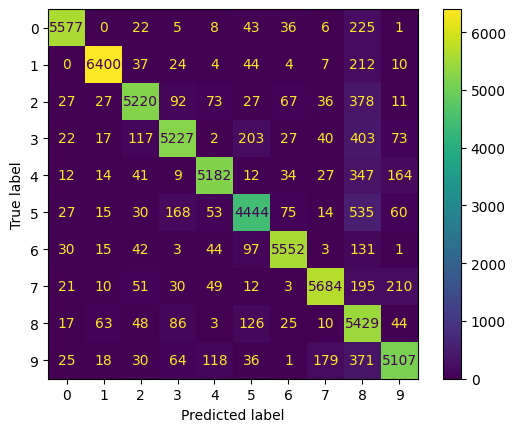

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))

y_train_pred = cross_val_predict(sgd_classifier, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

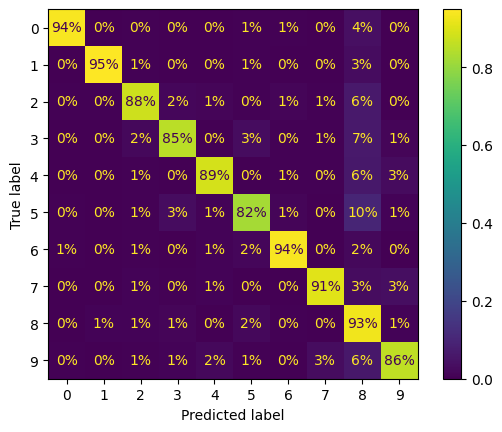

In [15]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

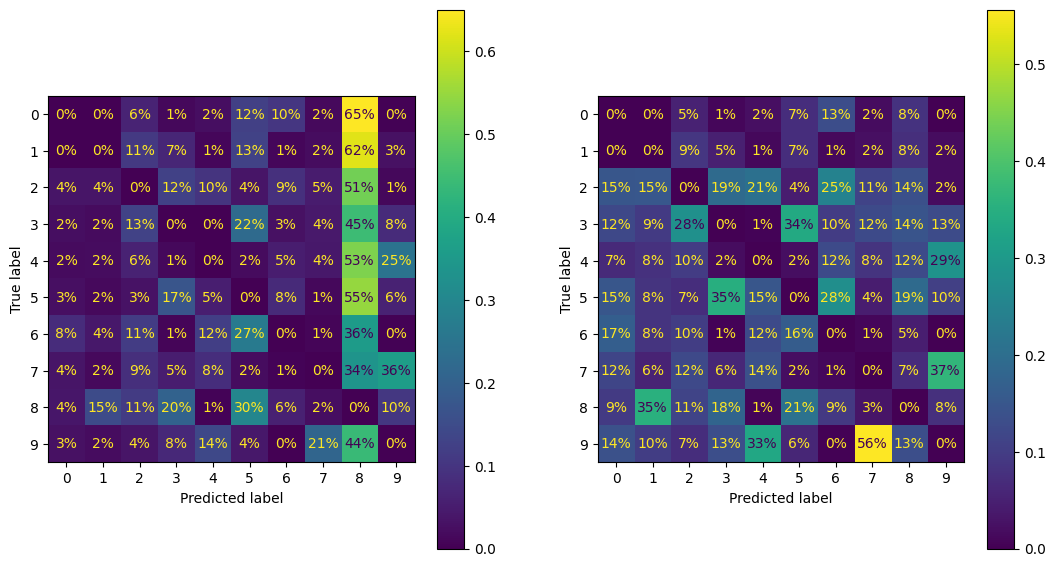

In [19]:
sample_weight = (y_train_pred != y_train)
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(121)
# błędy normalizowane po wierszach (65% błędów popełnionych przez model na zerach to klasyfikacja jako 8)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%", ax=ax)
ax = fig.add_subplot(122)
# błędy normalizowane po kolumnach (56% nieprawidłowo sklasyfikowanych 7 to w rzeczywistości 9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%", ax=ax)
plt.show()

Klasyfikacja wieloetykietowa

In [17]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

# zwraca dwie etykiety, czy liczba jest większa od 7 oraz czy jest parzysta
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [20]:
# uśredniony wynik f1 dla wszystkich etykiet
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")
# w przypadku różnych wag etykiet (różnice w ilości danych dla etykiet) można użyć average="weighted"

0.976410265560605

In [21]:
from sklearn.multioutput import ClassifierChain

# sekwencyjne uzyskiwanie etykiet z klasyfikatora nieobsługującego natywnie klasyfikacji wieloetykietowej
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)